Loading data from data_2/drug4k_smiles-embeddings.xlsx ...
Found 768 embedding dimensions
Data shape: (3839, 768)
Train set: 2687 samples (70.0%)
Validation set: 576 samples (15.0%)
Test set: 576 samples (15.0%)
VAE(
  (fc1): Linear(in_features=768, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=32, bias=True)
  (fc_dec1): Linear(in_features=32, out_features=128, bias=True)
  (fc_out_mean): Linear(in_features=128, out_features=768, bias=True)
  (fc_out_logvar): Linear(in_features=128, out_features=768, bias=True)
  (relu): ReLU()
)
Epoch 001 | Train: loss 1106.5298 recon 1103.2897 kld 3.2400 | Val: loss 1091.8823 recon 1085.6430 kld 6.2393
Epoch 002 | Train: loss 1078.3349 recon 1068.1332 kld 10.2018 | Val: loss 1049.8193 recon 1035.5048 kld 14.3144
Epoch 003 | Train: loss 1031.6507 recon 1015.1623 kld 16.4884 | Val: loss 1009.3405 recon 988.8979 kld 20.4426
Epoch 004 | Train: loss 995.6501

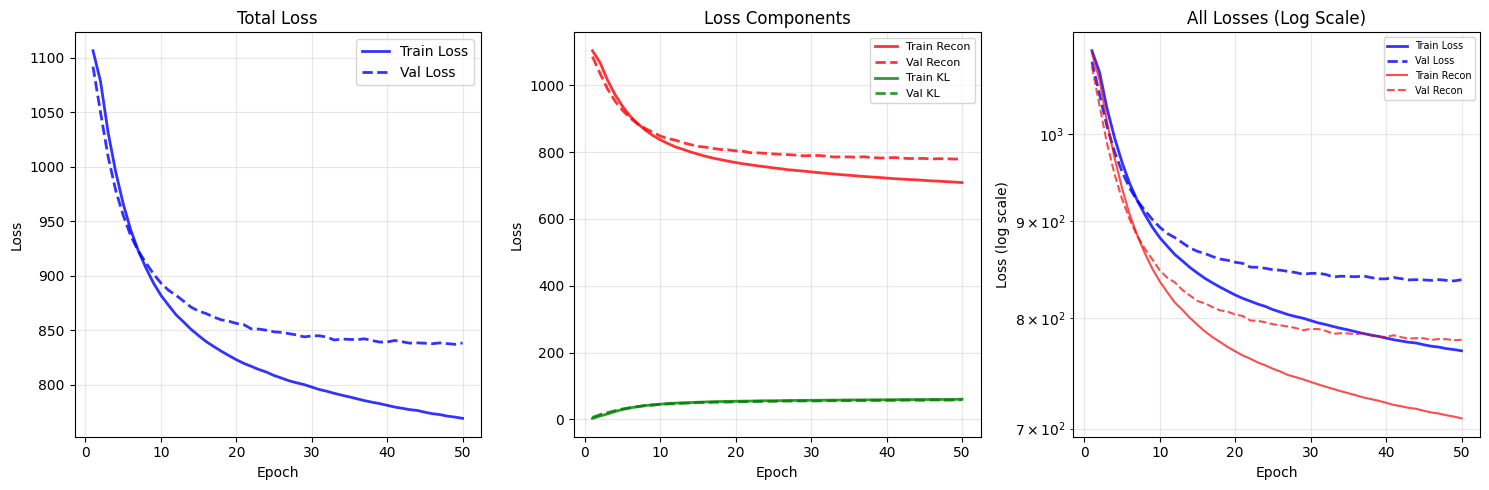


Computing evaluation metrics on Train/Val/Test sets...

TRAIN Set Metrics:
  R² Score:           0.587057
  Explained Variance: 0.587057
  Mean Squared Error: 0.413125
  Mean Absolute Error: 0.501440
  RMSE:               0.642748
  Per-sample R² - Mean: 0.579685, Median: 0.570959, Std: 0.118533

VAL Set Metrics:
  R² Score:           0.523444
  Explained Variance: 0.523444
  Mean Squared Error: 0.471235
  Mean Absolute Error: 0.534208
  RMSE:               0.686466
  Per-sample R² - Mean: 0.519945, Median: 0.506055, Std: 0.122324

TEST Set Metrics:
  R² Score:           0.539873
  Explained Variance: 0.539873
  Mean Squared Error: 0.464317
  Mean Absolute Error: 0.532918
  RMSE:               0.681408
  Per-sample R² - Mean: 0.533182, Median: 0.519775, Std: 0.120957

95% Confidence Interval Coverage:

Train Set:  95.37% of values within predicted 95% CI
Val Set:    92.98% of values within predicted 95% CI
Test Set:   93.04% of values within predicted 95% CI

Expected:   ~95% (if pred

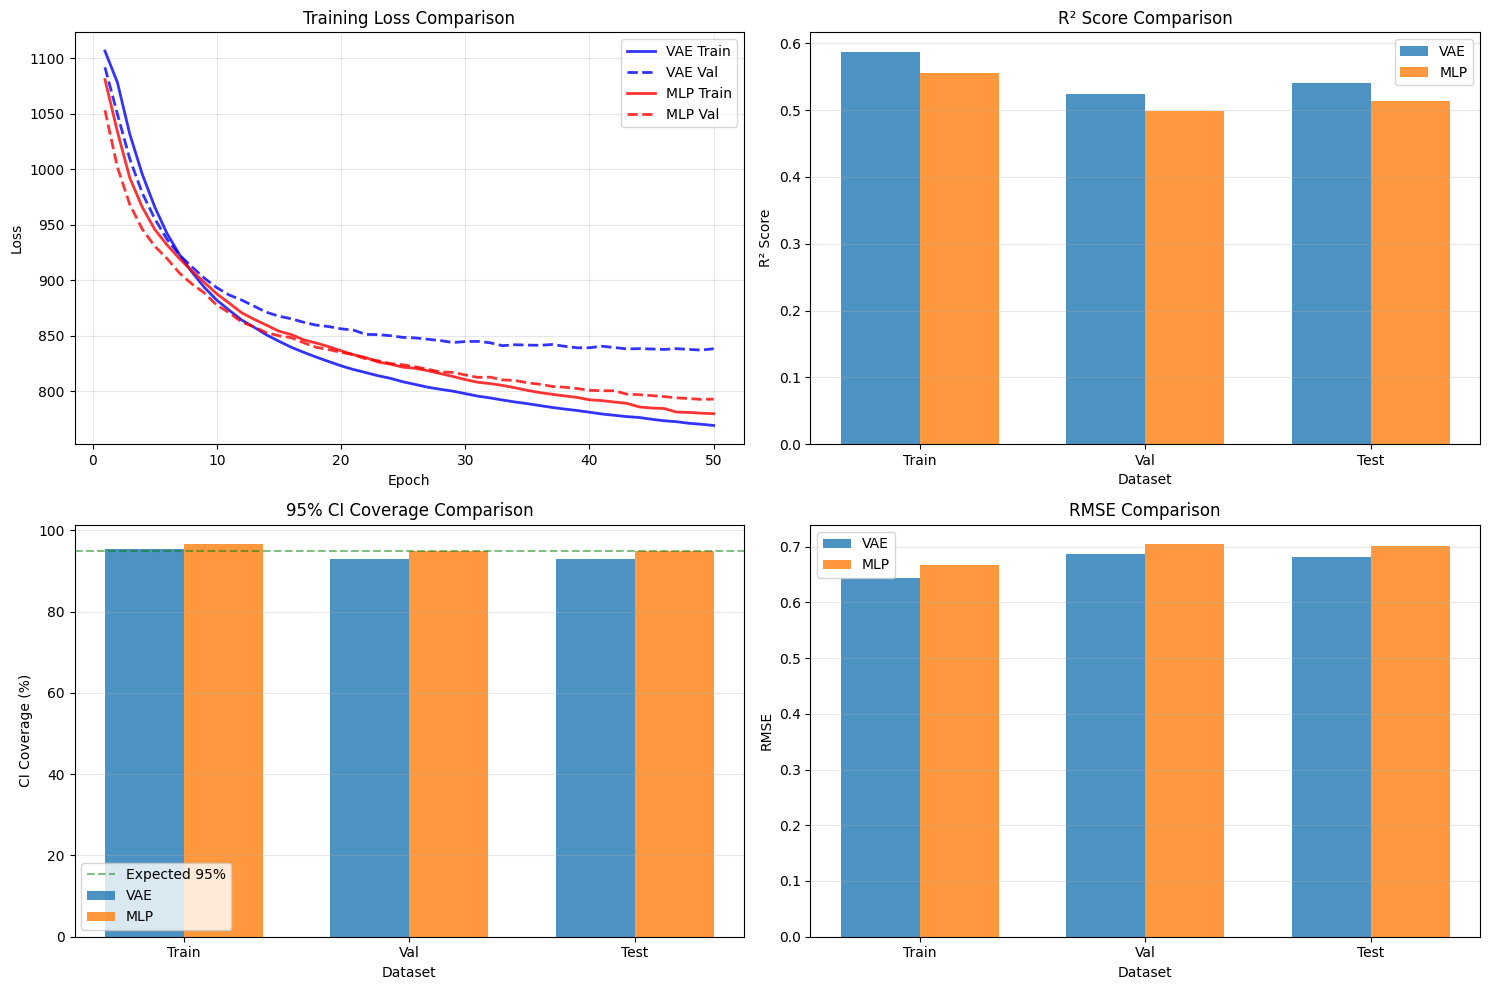

Saved MLP model to data_2/mlp_drug4k.pt

BENCHMARK COMPLETE


In [4]:
#!/usr/bin/env python3
"""
Train a Variational Autoencoder (VAE) on DRUG-seq compound embeddings.

Input:
    data_2/drug4k_smiles-embeddings.xlsx

Columns expected:
    cmpd_sample_id, inchi_key, smiles, cas_number, moa, 0, 1, 2, ...

Output:
    data_2/vae_drug4k.pt                       - VAE state dict
    data_2/vae_drug4k_latent.parquet          - latent vectors per compound
"""

import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


# -----------------------------
# Config
# -----------------------------

DATA_PATH = Path("data_2") / "drug4k_smiles-embeddings.xlsx"
OUT_DIR = Path("data_2")

LATENT_DIM = 32          # size of VAE latent space
HIDDEN_DIM = 128         # hidden layer size
BATCH_SIZE = 128
LR = 1e-3
N_EPOCHS = 50
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# -----------------------------
# Data loading and preprocessing
# -----------------------------

print(f"Loading data from {DATA_PATH} ...")
# Suppress openpyxl warnings about invalid date cells
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")
    df = pd.read_excel(DATA_PATH)

# Keep id columns for later, embeddings for training
id_cols = ["cmpd_sample_id", "inchi_key", "smiles", "cas_number", "moa"]
id_cols = [c for c in id_cols if c in df.columns]

# Numeric embedding columns (0, 1, 2, ...)
emb_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Found {len(emb_cols)} embedding dimensions")

X = df[emb_cols].to_numpy().astype(np.float32)

# Normalize embeddings
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

print(f"Data shape: {X_scaled.shape}")

# Split data into train/validation/test sets
# First split: 85% train+val, 15% test
X_train_val, X_test, idx_train_val, idx_test = train_test_split(
    X_scaled, np.arange(len(X_scaled)), test_size=0.15, random_state=42
)
# Second split: 70% train, 15% validation (of total)
X_train, X_val, idx_train, idx_val = train_test_split(
    X_train_val, idx_train_val, test_size=0.1765, random_state=42  # 0.1765 ≈ 15/85
)

print(f"Train set: {len(X_train)} samples ({len(X_train)/len(X_scaled)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X_scaled)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X_scaled)*100:.1f}%)")


class EmbDataset(Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(X)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx]


# Create datasets - only train data for training
train_dataset = EmbDataset(X_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

# Also create validation loader for evaluation during training
val_dataset = EmbDataset(X_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


# -----------------------------
# VAE model
# -----------------------------

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder - shared layers
        self.fc_dec1 = nn.Linear(latent_dim, hidden_dim)
        # Separate output layers for mean and log-variance of gene expression distribution
        self.fc_out_mean = nn.Linear(hidden_dim, input_dim)
        self.fc_out_logvar = nn.Linear(hidden_dim, input_dim)

        self.relu = nn.ReLU()

    def encode(self, x):
        h = self.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        # Shared hidden layer
        h = self.relu(self.fc_dec1(z))
        # Separate outputs for mean and log-variance
        recon_mean = self.fc_out_mean(h)
        recon_logvar = self.fc_out_logvar(h)
        return recon_mean, recon_logvar

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_mean, recon_logvar = self.decode(z)
        return recon_mean, recon_logvar, mu, logvar


input_dim = X_scaled.shape[1]
model = VAE(input_dim=input_dim, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print(model)


def vae_loss(recon_mean, recon_logvar, x, mu, logvar):
    """
    VAE loss with negative log likelihood for gene expression reconstruction.
    
    Args:
        recon_mean: Predicted mean of gene expression distribution [batch, features]
        recon_logvar: Predicted log-variance of gene expression distribution [batch, features]
        x: True gene expression values [batch, features]
        mu: Encoder mean [batch, latent_dim]
        logvar: Encoder log-variance [batch, latent_dim]
    """
    # Negative log likelihood for normal distribution
    # NLL = -log p(x | μ, σ²) = 0.5 * log(2π) + 0.5 * log(σ²) + 0.5 * (x - μ)²/σ²
    # where logvar = log(σ²)
    # NLL = 0.5 * log(2π) + 0.5 * logvar + 0.5 * (x - μ)² * exp(-logvar)
    const = 0.5 * np.log(2.0 * np.pi)
    recon_loss = torch.sum(
        const + 0.5 * recon_logvar + 0.5 * (x - recon_mean).pow(2) * torch.exp(-recon_logvar)
    )
    
    # KL divergence
    kld = 0.5 * torch.sum(torch.exp(logvar) + mu.pow(2) - 1.0 - logvar)
    
    return recon_loss + kld, recon_loss, kld


# -----------------------------
# Training loop
# -----------------------------

# Track training metrics
train_losses = []
train_recon_losses = []
train_kld_losses = []
val_losses = []
val_recon_losses = []
val_kld_losses = []

model.train()
for epoch in range(1, N_EPOCHS + 1):
    # Training phase
    model.train()
    total_loss = 0.0
    total_recon = 0.0
    total_kld = 0.0
    n_samples = 0

    for batch in train_loader:
        batch = batch.to(DEVICE)

        optimizer.zero_grad()
        recon_mean, recon_logvar, mu, logvar = model(batch)
        loss, recon_loss, kld = vae_loss(recon_mean, recon_logvar, batch, mu, logvar)
        loss.backward()
        optimizer.step()

        bs = batch.size(0)
        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kld += kld.item()
        n_samples += bs

    avg_loss = total_loss / n_samples
    avg_recon = total_recon / n_samples
    avg_kld = total_kld / n_samples

    # Track training metrics
    train_losses.append(avg_loss)
    train_recon_losses.append(avg_recon)
    train_kld_losses.append(avg_kld)

    # Validation phase
    model.eval()
    val_total_loss = 0.0
    val_total_recon = 0.0
    val_total_kld = 0.0
    val_n_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(DEVICE)
            recon_mean, recon_logvar, mu, logvar = model(batch)
            loss, recon_loss, kld = vae_loss(recon_mean, recon_logvar, batch, mu, logvar)

            bs = batch.size(0)
            val_total_loss += loss.item()
            val_total_recon += recon_loss.item()
            val_total_kld += kld.item()
            val_n_samples += bs

    val_avg_loss = val_total_loss / val_n_samples
    val_avg_recon = val_total_recon / val_n_samples
    val_avg_kld = val_total_kld / val_n_samples

    # Track validation metrics
    val_losses.append(val_avg_loss)
    val_recon_losses.append(val_avg_recon)
    val_kld_losses.append(val_avg_kld)

    print(
        f"Epoch {epoch:03d} | "
        f"Train: loss {avg_loss:.4f} recon {avg_recon:.4f} kld {avg_kld:.4f} | "
        f"Val: loss {val_avg_loss:.4f} recon {val_avg_recon:.4f} kld {val_avg_kld:.4f}"
    )


# -----------------------------
# Plot training curves
# -----------------------------

plt.figure(figsize=(15, 5))

epochs = range(1, N_EPOCHS + 1)

# Plot 1: Total loss (train vs validation)
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, 'b-', linewidth=2, label='Train Loss', alpha=0.8)
plt.plot(epochs, val_losses, 'b--', linewidth=2, label='Val Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 2: Reconstruction and KL divergence losses (train vs validation)
plt.subplot(1, 3, 2)
plt.plot(epochs, train_recon_losses, 'r-', linewidth=2, label='Train Recon', alpha=0.8)
plt.plot(epochs, val_recon_losses, 'r--', linewidth=2, label='Val Recon', alpha=0.8)
plt.plot(epochs, train_kld_losses, 'g-', linewidth=2, label='Train KL', alpha=0.8)
plt.plot(epochs, val_kld_losses, 'g--', linewidth=2, label='Val KL', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Components')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=8)

# Plot 3: Log scale for better visualization
plt.subplot(1, 3, 3)
plt.plot(epochs, train_losses, 'b-', linewidth=2, label='Train Loss', alpha=0.8)
plt.plot(epochs, val_losses, 'b--', linewidth=2, label='Val Loss', alpha=0.8)
plt.plot(epochs, train_recon_losses, 'r-', linewidth=1.5, label='Train Recon', alpha=0.7)
plt.plot(epochs, val_recon_losses, 'r--', linewidth=1.5, label='Val Recon', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('All Losses (Log Scale)')
plt.yscale('log')
plt.grid(True, alpha=0.3, which='both')
plt.legend(fontsize=7)

plt.tight_layout()
plt.savefig(OUT_DIR / "vae_training_curves.png", dpi=150, bbox_inches='tight')
print(f"\nSaved training curves to {OUT_DIR / 'vae_training_curves.png'}")
plt.show()


# -----------------------------
# Evaluation metrics on Train/Val/Test sets
# -----------------------------

def compute_metrics(X_true, X_recon, set_name):
    """Compute reconstruction metrics for a dataset."""
    # Flatten for metric computation
    X_true_flat = X_true.flatten()
    X_recon_flat = X_recon.flatten()
    
    # Compute metrics
    r2 = r2_score(X_true_flat, X_recon_flat)
    mse = mean_squared_error(X_true_flat, X_recon_flat)
    mae = mean_absolute_error(X_true_flat, X_recon_flat)
    explained_var = explained_variance_score(X_true_flat, X_recon_flat)
    
    # Per-sample R²
    sample_r2s = []
    for i in range(len(X_true)):
        sample_r2s.append(r2_score(X_true[i], X_recon[i]))
    sample_r2s = np.array(sample_r2s)
    
    return {
        'r2': r2,
        'explained_var': explained_var,
        'mse': mse,
        'mae': mae,
        'rmse': np.sqrt(mse),
        'sample_r2_mean': sample_r2s.mean(),
        'sample_r2_median': np.median(sample_r2s),
        'sample_r2_std': sample_r2s.std(),
        'sample_r2_min': sample_r2s.min(),
        'sample_r2_max': sample_r2s.max(),
    }

print("\n" + "="*60)
print("Computing evaluation metrics on Train/Val/Test sets...")
print("="*60)

model.eval()
metrics = {}

# Evaluate on training set
with torch.no_grad():
    X_train_tensor = torch.from_numpy(X_train).to(DEVICE)
    X_train_recon_mean, X_train_recon_logvar, _, _ = model(X_train_tensor)
    X_train_recon = X_train_recon_mean.cpu().numpy()
    X_train_recon_logvar_np = X_train_recon_logvar.cpu().numpy()
metrics['train'] = compute_metrics(X_train, X_train_recon, 'Train')

# Evaluate on validation set
with torch.no_grad():
    X_val_tensor = torch.from_numpy(X_val).to(DEVICE)
    X_val_recon_mean, X_val_recon_logvar, _, _ = model(X_val_tensor)
    X_val_recon = X_val_recon_mean.cpu().numpy()
    X_val_recon_logvar_np = X_val_recon_logvar.cpu().numpy()
metrics['val'] = compute_metrics(X_val, X_val_recon, 'Val')

# Evaluate on test set
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test).to(DEVICE)
    X_test_recon_mean, X_test_recon_logvar, _, _ = model(X_test_tensor)
    X_test_recon = X_test_recon_mean.cpu().numpy()
    X_test_recon_logvar_np = X_test_recon_logvar.cpu().numpy()
metrics['test'] = compute_metrics(X_test, X_test_recon, 'Test')

# Print metrics
for set_name in ['train', 'val', 'test']:
    m = metrics[set_name]
    print(f"\n{set_name.upper()} Set Metrics:")
    print(f"  R² Score:           {m['r2']:.6f}")
    print(f"  Explained Variance: {m['explained_var']:.6f}")
    print(f"  Mean Squared Error: {m['mse']:.6f}")
    print(f"  Mean Absolute Error: {m['mae']:.6f}")
    print(f"  RMSE:               {m['rmse']:.6f}")
    print(f"  Per-sample R² - Mean: {m['sample_r2_mean']:.6f}, Median: {m['sample_r2_median']:.6f}, Std: {m['sample_r2_std']:.6f}")

print("="*60 + "\n")

# -----------------------------
# Compute 95% Confidence Interval Coverage
# -----------------------------

def compute_ci_coverage(X_true, X_pred_mean, X_pred_logvar, confidence=0.95):
    """
    Compute the percentage of true values within predicted confidence intervals.
    
    Args:
        X_true: True values [n_samples, n_features]
        X_pred_mean: Predicted means [n_samples, n_features]
        X_pred_logvar: Predicted log-variances [n_samples, n_features]
        confidence: Confidence level (default 0.95 for 95% CI)
    
    Returns:
        Coverage percentage (0-100)
    """
    # Convert log-variance to standard deviation
    std = np.exp(0.5 * X_pred_logvar)
    
    # Compute z-score for confidence interval (1.96 for 95%, 2.576 for 99%)
    z_score = 1.96 if confidence == 0.95 else 2.576 if confidence == 0.99 else None
    if z_score is None:
        raise ValueError(f"Confidence level {confidence} not supported. Use 0.95 or 0.99")
    
    # Compute confidence intervals
    lower_bound = X_pred_mean - z_score * std
    upper_bound = X_pred_mean + z_score * std
    
    # Check if true values are within intervals
    within_ci = (X_true >= lower_bound) & (X_true <= upper_bound)
    
    # Compute coverage percentage
    coverage = 100.0 * within_ci.sum() / within_ci.size
    
    return coverage

print("="*60)
print("95% Confidence Interval Coverage:")
print("="*60)

# Compute coverage for each set
train_ci_coverage = compute_ci_coverage(X_train, X_train_recon, X_train_recon_logvar_np, confidence=0.95)
val_ci_coverage = compute_ci_coverage(X_val, X_val_recon, X_val_recon_logvar_np, confidence=0.95)
test_ci_coverage = compute_ci_coverage(X_test, X_test_recon, X_test_recon_logvar_np, confidence=0.95)

print(f"\nTrain Set:  {train_ci_coverage:.2f}% of values within predicted 95% CI")
print(f"Val Set:    {val_ci_coverage:.2f}% of values within predicted 95% CI")
print(f"Test Set:   {test_ci_coverage:.2f}% of values within predicted 95% CI")
print(f"\nExpected:   ~95% (if predictions are well-calibrated)")
print("="*60 + "\n")

# Add CI coverage to metrics
metrics['train']['ci_coverage_95'] = train_ci_coverage
metrics['val']['ci_coverage_95'] = val_ci_coverage
metrics['test']['ci_coverage_95'] = test_ci_coverage


# -----------------------------
# Save model and latent space
# -----------------------------

OUT_DIR.mkdir(parents=True, exist_ok=True)
model_path = OUT_DIR / "vae_drug4k.pt"
torch.save(
    {
        "state_dict": model.state_dict(),
        "input_dim": input_dim,
        "hidden_dim": HIDDEN_DIM,
        "latent_dim": LATENT_DIM,
        "scaler_mean": scaler.mean_,
        "scaler_scale": scaler.scale_,
        "emb_cols": emb_cols,
        "metrics": {
            "train": {
                "r2_score": float(metrics['train']['r2']),
                "explained_variance": float(metrics['train']['explained_var']),
                "mse": float(metrics['train']['mse']),
                "mae": float(metrics['train']['mae']),
                "rmse": float(metrics['train']['rmse']),
                "per_sample_r2": {
                    "mean": float(metrics['train']['sample_r2_mean']),
                    "median": float(metrics['train']['sample_r2_median']),
                    "std": float(metrics['train']['sample_r2_std']),
                    "min": float(metrics['train']['sample_r2_min']),
                    "max": float(metrics['train']['sample_r2_max']),
                }
            },
            "validation": {
                "r2_score": float(metrics['val']['r2']),
                "explained_variance": float(metrics['val']['explained_var']),
                "mse": float(metrics['val']['mse']),
                "mae": float(metrics['val']['mae']),
                "rmse": float(metrics['val']['rmse']),
                "per_sample_r2": {
                    "mean": float(metrics['val']['sample_r2_mean']),
                    "median": float(metrics['val']['sample_r2_median']),
                    "std": float(metrics['val']['sample_r2_std']),
                    "min": float(metrics['val']['sample_r2_min']),
                    "max": float(metrics['val']['sample_r2_max']),
                }
            },
            "test": {
                "r2_score": float(metrics['test']['r2']),
                "explained_variance": float(metrics['test']['explained_var']),
                "mse": float(metrics['test']['mse']),
                "mae": float(metrics['test']['mae']),
                "rmse": float(metrics['test']['rmse']),
                "per_sample_r2": {
                    "mean": float(metrics['test']['sample_r2_mean']),
                    "median": float(metrics['test']['sample_r2_median']),
                    "std": float(metrics['test']['sample_r2_std']),
                    "min": float(metrics['test']['sample_r2_min']),
                    "max": float(metrics['test']['sample_r2_max']),
                }
            }
        }
    },
    model_path,
)
print(f"Saved VAE model to {model_path}")

# Compute latent vectors for all compounds (train + val + test)
# Combine all data in original order
all_indices = np.concatenate([idx_train, idx_val, idx_test])
all_data = np.concatenate([X_train, X_val, X_test])

# Reorder to match original dataframe order
sort_order = np.argsort(all_indices)
all_data_ordered = all_data[sort_order]

model.eval()
with torch.no_grad():
    X_all_tensor = torch.from_numpy(all_data_ordered).to(DEVICE)
    mu, logvar = model.encode(X_all_tensor)
    z = mu.cpu().numpy()  # use mean as latent embedding

latent_cols = [f"z_{i}" for i in range(LATENT_DIM)]
latent_df = pd.DataFrame(z, columns=latent_cols)

# Attach ids if present
for c in id_cols:
    latent_df[c] = df[c].values

# Convert object columns to strings to handle datetime objects and mixed types
for c in id_cols:
    if latent_df[c].dtype == 'object':
        latent_df[c] = latent_df[c].astype(str)

latent_out_path = OUT_DIR / "vae_drug4k_latent.parquet"
latent_df.to_parquet(latent_out_path, index=False)
print(f"Saved latent vectors to {latent_out_path}")
print(latent_df.head())


# ============================================================================
# MLP Autoencoder Architecture (Non-Variational)
# ============================================================================

class MLPAutoencoder(nn.Module):
    """
    Simple MLP-based autoencoder without variational constraints.
    Predicts distribution parameters (mean and log-variance) similar to VAE.
    """
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        # Encoder
        self.encoder_fc1 = nn.Linear(input_dim, hidden_dim)
        self.encoder_fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.encoder_out = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder - shared layers
        self.decoder_fc1 = nn.Linear(latent_dim, hidden_dim)
        self.decoder_fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Separate output layers for mean and log-variance
        self.decoder_out_mean = nn.Linear(hidden_dim, input_dim)
        self.decoder_out_logvar = nn.Linear(hidden_dim, input_dim)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
    
    def encode(self, x):
        """Encode input to latent representation."""
        h = self.relu(self.encoder_fc1(x))
        h = self.dropout(h)
        h = self.relu(self.encoder_fc2(h))
        z = self.encoder_out(h)
        return z
    
    def decode(self, z):
        """Decode latent representation to distribution parameters."""
        h = self.relu(self.decoder_fc1(z))
        h = self.dropout(h)
        h = self.relu(self.decoder_fc2(h))
        recon_mean = self.decoder_out_mean(h)
        recon_logvar = self.decoder_out_logvar(h)
        return recon_mean, recon_logvar
    
    def forward(self, x):
        """Forward pass."""
        z = self.encode(x)
        recon_mean, recon_logvar = self.decode(z)
        return recon_mean, recon_logvar


def mlp_loss(recon_mean, recon_logvar, x):
    """
    Loss function for MLP autoencoder (NLL only, no KL term).
    """
    # Negative log likelihood for normal distribution
    const = 0.5 * np.log(2.0 * np.pi)
    recon_loss = torch.sum(
        const + 0.5 * recon_logvar + 0.5 * (x - recon_mean).pow(2) * torch.exp(-recon_logvar)
    )
    return recon_loss, recon_loss


# ============================================================================
# Benchmark: Train MLP Autoencoder and Compare with VAE
# ============================================================================

print("\n" + "="*70)
print("BENCHMARKING: MLP Autoencoder vs VAE")
print("="*70)

# Initialize MLP model
mlp_model = MLPAutoencoder(
    input_dim=input_dim, 
    hidden_dim=HIDDEN_DIM, 
    latent_dim=LATENT_DIM
).to(DEVICE)
mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), lr=LR)

print(f"\nMLP Model Architecture:")
print(mlp_model)
print(f"\nParameters: {sum(p.numel() for p in mlp_model.parameters()):,}")
print(f"VAE Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Training metrics for MLP
mlp_train_losses = []
mlp_val_losses = []

print(f"\nTraining MLP Autoencoder for {N_EPOCHS} epochs...")
mlp_model.train()
for epoch in range(1, N_EPOCHS + 1):
    # Training phase
    mlp_model.train()
    total_loss = 0.0
    n_samples = 0
    
    for batch in train_loader:
        batch = batch.to(DEVICE)
        mlp_optimizer.zero_grad()
        recon_mean, recon_logvar = mlp_model(batch)
        loss, _ = mlp_loss(recon_mean, recon_logvar, batch)
        loss.backward()
        mlp_optimizer.step()
        
        bs = batch.size(0)
        total_loss += loss.item()
        n_samples += bs
    
    avg_loss = total_loss / n_samples
    mlp_train_losses.append(avg_loss)
    
    # Validation phase
    mlp_model.eval()
    val_total_loss = 0.0
    val_n_samples = 0
    
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(DEVICE)
            recon_mean, recon_logvar = mlp_model(batch)
            loss, _ = mlp_loss(recon_mean, recon_logvar, batch)
            
            bs = batch.size(0)
            val_total_loss += loss.item()
            val_n_samples += bs
    
    val_avg_loss = val_total_loss / val_n_samples
    mlp_val_losses.append(val_avg_loss)
    
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Train Loss: {avg_loss:.4f} | Val Loss: {val_avg_loss:.4f}")

print("\n" + "="*70)
print("EVALUATING MLP MODEL")
print("="*70)

# Evaluate MLP on all sets
mlp_metrics = {}

# Evaluate on training set
mlp_model.eval()
with torch.no_grad():
    X_train_tensor = torch.from_numpy(X_train).to(DEVICE)
    X_train_mlp_mean, X_train_mlp_logvar = mlp_model(X_train_tensor)
    X_train_mlp_recon = X_train_mlp_mean.cpu().numpy()
    X_train_mlp_logvar_np = X_train_mlp_logvar.cpu().numpy()
mlp_metrics['train'] = compute_metrics(X_train, X_train_mlp_recon, 'Train')

# Evaluate on validation set
with torch.no_grad():
    X_val_tensor = torch.from_numpy(X_val).to(DEVICE)
    X_val_mlp_mean, X_val_mlp_logvar = mlp_model(X_val_tensor)
    X_val_mlp_recon = X_val_mlp_mean.cpu().numpy()
    X_val_mlp_logvar_np = X_val_mlp_logvar.cpu().numpy()
mlp_metrics['val'] = compute_metrics(X_val, X_val_mlp_recon, 'Val')

# Evaluate on test set
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test).to(DEVICE)
    X_test_mlp_mean, X_test_mlp_logvar = mlp_model(X_test_tensor)
    X_test_mlp_recon = X_test_mlp_mean.cpu().numpy()
    X_test_mlp_logvar_np = X_test_mlp_logvar.cpu().numpy()
mlp_metrics['test'] = compute_metrics(X_test, X_test_mlp_recon, 'Test')

# Compute CI coverage for MLP
mlp_train_ci = compute_ci_coverage(X_train, X_train_mlp_recon, X_train_mlp_logvar_np, confidence=0.95)
mlp_val_ci = compute_ci_coverage(X_val, X_val_mlp_recon, X_val_mlp_logvar_np, confidence=0.95)
mlp_test_ci = compute_ci_coverage(X_test, X_test_mlp_recon, X_test_mlp_logvar_np, confidence=0.95)

mlp_metrics['train']['ci_coverage_95'] = mlp_train_ci
mlp_metrics['val']['ci_coverage_95'] = mlp_val_ci
mlp_metrics['test']['ci_coverage_95'] = mlp_test_ci

# ============================================================================
# Comparison Table
# ============================================================================

print("\n" + "="*70)
print("COMPARISON: VAE vs MLP Autoencoder")
print("="*70)

# Calculate and display parameter counts
vae_params = sum(p.numel() for p in model.parameters())
mlp_params = sum(p.numel() for p in mlp_model.parameters())
vae_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
mlp_trainable = sum(p.numel() for p in mlp_model.parameters() if p.requires_grad)

print("\nArchitecture Summary:")
print(f"{'Metric':<25} {'VAE':<20} {'MLP':<20}")
print("-" * 65)
print(f"{'Total Parameters':<25} {vae_params:>19,} {mlp_params:>19,}")
print(f"{'Trainable Parameters':<25} {vae_trainable:>19,} {mlp_trainable:>19,}")
print(f"{'Parameter Difference':<25} {'-'*19} {mlp_params - vae_params:>+19,} ({((mlp_params - vae_params) / vae_params * 100):>+6.1f}%)")
print(f"{'Architecture Type':<25} {'Variational':<20} {'Standard':<20}")
print(f"{'KL Regularization':<25} {'Yes (adds constraint)':<20} {'No':<20}")

comparison_metrics = ['r2', 'mse', 'mae', 'rmse', 'ci_coverage_95']
print("\nTest Set Metrics:")
print(f"{'Metric':<20} {'VAE':<15} {'MLP':<15} {'Difference':<15}")
print("-" * 65)

for metric in comparison_metrics:
    vae_val = metrics['test'][metric]
    mlp_val = mlp_metrics['test'][metric]
    diff = mlp_val - vae_val
    diff_pct = (diff / vae_val * 100) if vae_val != 0 else 0
    
    metric_name = metric.replace('_', ' ').title()
    if metric == 'ci_coverage_95':
        print(f"{metric_name:<20} {vae_val:>6.2f}%      {mlp_val:>6.2f}%      {diff:>+6.2f}% ({diff_pct:>+5.1f}%)")
    else:
        print(f"{metric_name:<20} {vae_val:>14.6f} {mlp_val:>14.6f} {diff:>+14.6f} ({diff_pct:>+5.1f}%)")

print("\nValidation Set Metrics:")
print(f"{'Metric':<20} {'VAE':<15} {'MLP':<15} {'Difference':<15}")
print("-" * 65)

for metric in comparison_metrics:
    vae_val = metrics['val'][metric]
    mlp_val = mlp_metrics['val'][metric]
    diff = mlp_val - vae_val
    diff_pct = (diff / vae_val * 100) if vae_val != 0 else 0
    
    metric_name = metric.replace('_', ' ').title()
    if metric == 'ci_coverage_95':
        print(f"{metric_name:<20} {vae_val:>6.2f}%      {mlp_val:>6.2f}%      {diff:>+6.2f}% ({diff_pct:>+5.1f}%)")
    else:
        print(f"{metric_name:<20} {vae_val:>14.6f} {mlp_val:>14.6f} {diff:>+14.6f} ({diff_pct:>+5.1f}%)")

# ============================================================================
# Comparison Plot
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs = range(1, N_EPOCHS + 1)

# Plot 1: Training loss comparison
axes[0, 0].plot(epochs, train_losses, 'b-', linewidth=2, label='VAE Train', alpha=0.8)
axes[0, 0].plot(epochs, val_losses, 'b--', linewidth=2, label='VAE Val', alpha=0.8)
axes[0, 0].plot(epochs, mlp_train_losses, 'r-', linewidth=2, label='MLP Train', alpha=0.8)
axes[0, 0].plot(epochs, mlp_val_losses, 'r--', linewidth=2, label='MLP Val', alpha=0.8)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Test set R² comparison
sets = ['Train', 'Val', 'Test']
vae_r2 = [metrics['train']['r2'], metrics['val']['r2'], metrics['test']['r2']]
mlp_r2 = [mlp_metrics['train']['r2'], mlp_metrics['val']['r2'], mlp_metrics['test']['r2']]
x = np.arange(len(sets))
width = 0.35
axes[0, 1].bar(x - width/2, vae_r2, width, label='VAE', alpha=0.8)
axes[0, 1].bar(x + width/2, mlp_r2, width, label='MLP', alpha=0.8)
axes[0, 1].set_xlabel('Dataset')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].set_title('R² Score Comparison')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(sets)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: CI Coverage comparison
vae_ci = [metrics['train']['ci_coverage_95'], metrics['val']['ci_coverage_95'], metrics['test']['ci_coverage_95']]
mlp_ci = [mlp_metrics['train']['ci_coverage_95'], mlp_metrics['val']['ci_coverage_95'], mlp_metrics['test']['ci_coverage_95']]
axes[1, 0].bar(x - width/2, vae_ci, width, label='VAE', alpha=0.8)
axes[1, 0].bar(x + width/2, mlp_ci, width, label='MLP', alpha=0.8)
axes[1, 0].axhline(y=95, color='g', linestyle='--', label='Expected 95%', alpha=0.5)
axes[1, 0].set_xlabel('Dataset')
axes[1, 0].set_ylabel('CI Coverage (%)')
axes[1, 0].set_title('95% CI Coverage Comparison')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(sets)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: RMSE comparison
vae_rmse = [metrics['train']['rmse'], metrics['val']['rmse'], metrics['test']['rmse']]
mlp_rmse = [mlp_metrics['train']['rmse'], mlp_metrics['val']['rmse'], mlp_metrics['test']['rmse']]
axes[1, 1].bar(x - width/2, vae_rmse, width, label='VAE', alpha=0.8)
axes[1, 1].bar(x + width/2, mlp_rmse, width, label='MLP', alpha=0.8)
axes[1, 1].set_xlabel('Dataset')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].set_title('RMSE Comparison')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(sets)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
benchmark_plot_path = OUT_DIR / "vae_vs_mlp_benchmark.png"
plt.savefig(benchmark_plot_path, dpi=150, bbox_inches='tight')
print(f"\nSaved benchmark comparison plot to {benchmark_plot_path}")
plt.show()

# Save MLP model
mlp_model_path = OUT_DIR / "mlp_drug4k.pt"
torch.save(
    {
        "state_dict": mlp_model.state_dict(),
        "input_dim": input_dim,
        "hidden_dim": HIDDEN_DIM,
        "latent_dim": LATENT_DIM,
        "scaler_mean": scaler.mean_,
        "scaler_scale": scaler.scale_,
        "emb_cols": emb_cols,
        "metrics": {
            "train": {k: float(v) for k, v in mlp_metrics['train'].items()},
            "validation": {k: float(v) for k, v in mlp_metrics['val'].items()},
            "test": {k: float(v) for k, v in mlp_metrics['test'].items()}
        }
    },
    mlp_model_path,
)
print(f"Saved MLP model to {mlp_model_path}")

print("\n" + "="*70)
print("BENCHMARK COMPLETE")
print("="*70)